In [12]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from scipy.special import softmax
import matplotlib.pyplot as plt
import optuna
from collections import Counter
from transformers import EarlyStoppingCallback

In [13]:
# Load dataset
file_path = "2_processed_data/labelled_dataset_revised.csv"
df = pd.read_csv(file_path, encoding="latin1")

valid = ['C', 'G', 'W/Q', 'OTH']
df = df[df['revised_argument_type'].isin(valid)].copy()

df['input'] = df['sentence']
label_map = {label: idx for idx, label in enumerate(valid)}
inv_label_map = {idx: label for label, idx in label_map.items()}
df['label'] = df['revised_argument_type'].map(label_map).astype(int)

In [ ]:
# Stratified Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['input'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

In [14]:
# Tokenizer and Model
model_ckpt = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, use_fast=True)

model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=len(valid),
    use_safetensors=True
)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenization
train_enc = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_enc = tokenizer(val_texts, truncation=True, padding=True, max_length=256)
train_dataset = Dataset.from_dict({
    'input_ids': train_enc['input_ids'],
    'attention_mask': train_enc['attention_mask'],
    'labels': train_labels
})
val_dataset = Dataset.from_dict({
    'input_ids': val_enc['input_ids'],
    'attention_mask': val_enc['attention_mask'],
    'labels': val_labels
})

In [22]:
# Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

In [ ]:
# Training Configuration
training_args = TrainingArguments(
    output_dir="logging/deberta/results",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,

    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,

    learning_rate=2e-5,
    weight_decay=0.05,
    num_train_epochs=2,

    fp16=torch.cuda.is_available(),

    dataloader_num_workers=4,
    dataloader_pin_memory=True,
    dataloader_prefetch_factor=2,

    logging_dir="logging/deberta/logs",
    logging_steps=100,
    save_total_limit=2
)

In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)

# Train
trainer.train()

C:\Users\user\AppData\Local\Temp\ipykernel_29004\1318337750.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.255500,0.254225,0.905192,0.884685
2,0.183900,0.237174,0.925278,0.908011


TrainOutput(global_step=10854, training_loss=0.2813241482220325, metrics={'train_runtime': 79576.1964, 'train_samples_per_second': 2.182, 'train_steps_per_second': 0.136, 'total_flos': 1.27613184910068e+16, 'train_loss': 0.2813241482220325, 'epoch': 2.0})


=== Classification Report ===
              precision    recall  f1-score   support

           C       0.90      0.94      0.92      3388
           G       0.94      0.94      0.94      5736
         W/Q       0.95      0.94      0.95      9830
         OTH       0.82      0.83      0.83      2753

    accuracy                           0.93     21707
   macro avg       0.90      0.91      0.91     21707
weighted avg       0.93      0.93      0.93     21707

Confusion Matrix:
 [[3176   23   98   91]
 [  29 5411  146  150]
 [ 183  183 9221  243]
 [ 140  143  193 2277]]


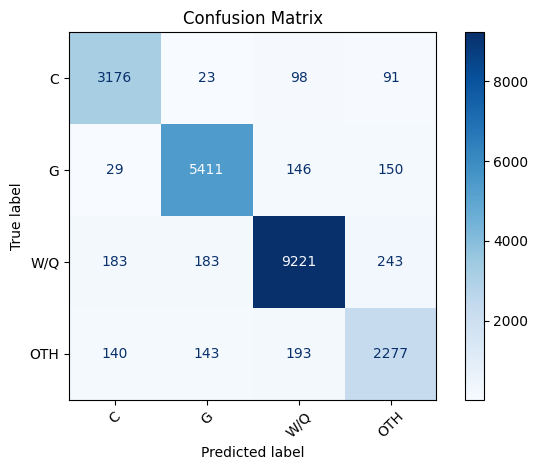

In [ ]:
# Final evaluation
preds = trainer.predict(val_dataset)
y_pred = np.argmax(preds.predictions, axis=1)

print("\n=== Classification Report ===")
labels_present = sorted(set(val_labels))
target_names_present = [inv_label_map[i] for i in labels_present]

print(classification_report(
    val_labels,
    y_pred,
    labels=labels_present,
    target_names=target_names_present,
    zero_division=0
))

# Confusion Matrix
y_true = val_labels

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = ['C', 'G', 'W/Q', 'OTH']

# Print numeric matrix
print("Confusion Matrix:\n", cm)

# Optional: Display as heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


=== ROC AUCs ===
C: AUC = 0.9949
G: AUC = 0.9949
W/Q: AUC = 0.9902
OTH: AUC = 0.9841
Micro-average AUC: 0.9927
Macro-average AUC: 0.9910


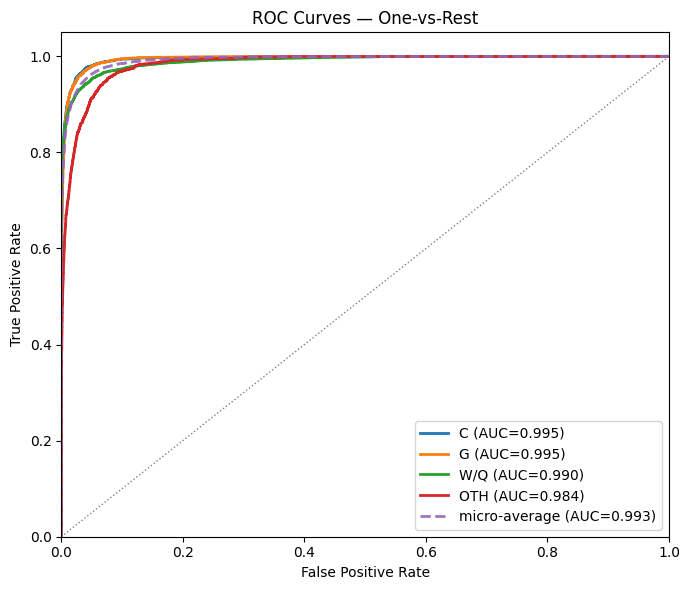

In [ ]:
# === ROC / AUC (one-vs-rest) ===
import numpy as np
from scipy.special import softmax
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Get class probabilities from logits
probs_all = softmax(preds.predictions, axis=1)

# Classes actually present in the validation labels (avoids ROC errors if a class is missing)
labels_present = sorted(set(y_true))
class_names_present = [inv_label_map[i] for i in labels_present]

# Binarize true labels
y_true_bin = label_binarize(np.array(y_true), classes=labels_present)

# Align probs to the present classes (columns are class indices)
probs = probs_all[:, labels_present]

# Compute per-class ROC and AUC
fprs, tprs, aucs = {}, {}, {}
for j, cls_id in enumerate(labels_present):
    # Skip if no positive samples for this class in y_true
    if y_true_bin[:, j].sum() == 0:
        continue
    fpr, tpr, _ = roc_curve(y_true_bin[:, j], probs[:, j])
    fprs[cls_id], tprs[cls_id] = fpr, tpr
    aucs[cls_id] = auc(fpr, tpr)

# Micro-average ROC/AUC
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), probs.ravel())
auc_micro = auc(fpr_micro, tpr_micro)

# Macro-average AUC (mean across available per-class AUCs)
auc_macro = float(np.mean(list(aucs.values()))) if len(aucs) > 0 else float("nan")

# Print AUCs
print("\n=== ROC AUCs ===")
for cls_id in labels_present:
    name = inv_label_map[cls_id]
    if cls_id in aucs:
        print(f"{name}: AUC = {aucs[cls_id]:.4f}")
    else:
        print(f"{name}: AUC = N/A (no positive examples)")
print(f"Micro-average AUC: {auc_micro:.4f}")
print(f"Macro-average AUC: {auc_macro:.4f}")

# Plot ROC curves
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 6))
# Per-class curves
for cls_id in labels_present:
    if cls_id in fprs:
        plt.plot(fprs[cls_id], tprs[cls_id], lw=2,
                 label=f"{inv_label_map[cls_id]} (AUC={aucs[cls_id]:.3f})")

# Micro-average
plt.plot(fpr_micro, tpr_micro, lw=2, linestyle="--",
         label=f"micro-average (AUC={auc_micro:.3f})", alpha=0.9)

# Chance line
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle=":")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — One-vs-Rest")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [ ]:
# Save Model
model.save_pretrained("3_model/deberta-v3")
tokenizer.save_pretrained("3_model/deberta-v3")

('3_model/deberta-v3\\tokenizer_config.json',
 '3_model/deberta-v3\\special_tokens_map.json',
 '3_model/deberta-v3\\spm.model',
 '3_model/deberta-v3\\added_tokens.json',
 '3_model/deberta-v3\\tokenizer.json')

In [ ]:
# ---------- 1) Find a debate/filename column & sample 100 debates ----------
filename_col = None
for cand in ["filename", "file_name", "debate_id", "doc", "source", "file", "topic_id"]:
    if cand in df.columns:
        filename_col = cand
        break
if filename_col is None:
    raise ValueError(
        "Could not find a filename/debate identifier column. "
        "Please ensure your CSV has one of: "
        "['filename','file_name','debate_id','doc','source','file','topic_id']"
    )

unique_files = df[filename_col].dropna().unique().tolist()
rng = np.random.default_rng(42)
sampled_files = rng.choice(unique_files, size=min(100, len(unique_files)), replace=False).tolist()
df_sample = df[df[filename_col].isin(sampled_files)].copy()

In [33]:
print("\n=== SAMPLING SUMMARY ===")
print(f"Identifier column: {filename_col}")
print(f"Unique debates total: {len(unique_files)}")
print(f"Sampled debates: {len(sampled_files)}")
print(f"Sampled rows: {len(df_sample)}")
print("Sample label counts:", Counter(df_sample["label"]))
print("Sampled file examples:", sampled_files[:5])


=== SAMPLING SUMMARY ===
Identifier column: filename
Unique debates total: 3738
Sampled debates: 100
Sampled rows: 2931
Sample label counts: Counter({2: 1251, 1: 870, 0: 458, 3: 352})
Sampled file examples: ['YBA_661_mandatory-retirement_con_DJ_explicit.trs.txt', 'WS_3196_immigration-us_pro.trs.txt', 'SSH_3301_freedom-of-speech_con_DJ_implicit.trs.txt', 'RG_2143_ban-abortions_pro.trs.txt', 'JL_985_free-market_con_TL_implicit.trs.txt']


In [34]:
# ---------- 2) Train/Val split on SAMPLED subset & show shapes ----------
train_texts_s, val_texts_s, train_labels_s, val_labels_s = train_test_split(
    df_sample['input'].tolist(),
    df_sample['label'].tolist(),
    test_size=0.2,
    stratify=df_sample['label'],
    random_state=42
)

In [35]:
print("\n=== SAMPLED SPLIT SHAPES ===")
print(f"train_texts: {len(train_texts_s)} | val_texts: {len(val_texts_s)}")
print("Train class balance:", Counter(train_labels_s))
print("Val class balance:", Counter(val_labels_s))


=== SAMPLED SPLIT SHAPES ===
train_texts: 2344 | val_texts: 587
Train class balance: Counter({2: 1000, 1: 696, 0: 366, 3: 282})
Val class balance: Counter({2: 251, 1: 174, 0: 92, 3: 70})


In [36]:
def make_hf_datasets(tokenizer, texts_train, labels_train, texts_val, labels_val, max_length=256):
    enc_tr = tokenizer(texts_train, truncation=True, padding=True, max_length=max_length)
    enc_va = tokenizer(texts_val,   truncation=True, padding=True, max_length=max_length)
    ds_train = Dataset.from_dict({
        "input_ids": enc_tr["input_ids"],
        "attention_mask": enc_tr["attention_mask"],
        "labels": labels_train
    })
    ds_val = Dataset.from_dict({
        "input_ids": enc_va["input_ids"],
        "attention_mask": enc_va["attention_mask"],
        "labels": labels_val
    })
    return ds_train, ds_val

In [37]:
# ---------- 3) Optuna HPO on sampled subset (10 trials) ----------
def objective(trial):
    # compact search space for quick tuning
    lr = trial.suggest_float("learning_rate", 1e-5, 5e-4, log=True)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1)
    batch_size = trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32])
    grad_accum = trial.suggest_categorical("gradient_accumulation_steps", [1, 2, 4])
    max_length = trial.suggest_categorical("max_length", [128, 256, 384])
    warmup_ratio = trial.suggest_float("warmup_ratio", 0.0, 0.15)
    num_epochs = trial.suggest_categorical("num_train_epochs", [1, 2])  # short for speed

    ds_train, ds_val = make_hf_datasets(
        tokenizer,
        train_texts_s, train_labels_s,
        val_texts_s,   val_labels_s,
        max_length=max_length
    )

    model_hpo = AutoModelForSequenceClassification.from_pretrained(
        model_ckpt, num_labels=len(valid), use_safetensors=True
    )

    args = TrainingArguments(
        output_dir=f"logging/deberta/hpo_trial_{trial.number}",
        overwrite_output_dir=True,
        do_train=True,
        do_eval=True,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,

        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=min(batch_size, 32),
        gradient_accumulation_steps=grad_accum,

        learning_rate=lr,
        weight_decay=weight_decay,
        num_train_epochs=num_epochs,
        warmup_ratio=warmup_ratio,

        fp16=torch.cuda.is_available(),
        logging_steps=50,
        save_total_limit=1,
        report_to=[],
        dataloader_num_workers=2,
        dataloader_pin_memory=True
    )

    trainer_hpo = Trainer(
        model=model_hpo,
        args=args,
        tokenizer=tokenizer,
        train_dataset=ds_train,
        eval_dataset=ds_val,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer_hpo.train()
    eval_res = trainer_hpo.evaluate(ds_val)
    return eval_res["eval_f1_macro"]

In [38]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, show_progress_bar=False)

[I 2025-09-05 00:49:38,060] A new study created in memory with name: no-name-e7508d6a-1ef2-479c-801c-c882d25ab5ef
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_41852\76716818.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eo

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.006541,0.538330,0.422446


[I 2025-09-05 00:58:21,882] Trial 0 finished with value: 0.42244582372486905 and parameters: {'learning_rate': 0.00011924010546566158, 'weight_decay': 0.013005547233699588, 'per_device_train_batch_size': 16, 'gradient_accumulation_steps': 4, 'max_length': 384, 'warmup_ratio': 0.014964375007602598, 'num_train_epochs': 1}. Best is trial 0 with value: 0.42244582372486905.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_41852\76716818.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
Trainer.tokenizer is now deprecated. You should use Tr

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.228506,0.427598,0.149761
2,No log,1.185956,0.441227,0.181822


[I 2025-09-05 01:28:19,789] Trial 1 finished with value: 0.18182225637085414 and parameters: {'learning_rate': 2.3195906945243005e-05, 'weight_decay': 0.07408236808579205, 'per_device_train_batch_size': 32, 'gradient_accumulation_steps': 4, 'max_length': 384, 'warmup_ratio': 0.12074195042999157, 'num_train_epochs': 2}. Best is trial 0 with value: 0.42244582372486905.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_41852\76716818.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
Trainer.tokenizer is now deprecated. You should use Trai

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.292700,1.268310,0.427598,0.149761


[I 2025-09-05 01:34:34,787] Trial 2 finished with value: 0.14976133651551313 and parameters: {'learning_rate': 0.0002917806577142837, 'weight_decay': 0.026797380610658672, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 1, 'max_length': 256, 'warmup_ratio': 0.06482607527537022, 'num_train_epochs': 1}. Best is trial 0 with value: 0.42244582372486905.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_41852\76716818.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
Trainer.tokenizer is now deprecated. You should use Train

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.259200,1.112914,0.488927,0.285239
2,1.116600,0.976508,0.572402,0.337930


[I 2025-09-05 02:00:35,483] Trial 3 finished with value: 0.3379295560271829 and parameters: {'learning_rate': 1.7383654969626447e-05, 'weight_decay': 0.013778787617354194, 'per_device_train_batch_size': 32, 'gradient_accumulation_steps': 1, 'max_length': 256, 'warmup_ratio': 0.00897111679558557, 'num_train_epochs': 2}. Best is trial 0 with value: 0.42244582372486905.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_41852\76716818.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
Trainer.tokenizer is now deprecated. You should use Trai

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.233403,0.427598,0.149761
2,No log,1.201434,0.427598,0.149761


[I 2025-09-05 02:19:08,521] Trial 4 finished with value: 0.14976133651551313 and parameters: {'learning_rate': 0.0004465400249300242, 'weight_decay': 0.09654159645883001, 'per_device_train_batch_size': 32, 'gradient_accumulation_steps': 4, 'max_length': 128, 'warmup_ratio': 0.07320802923753635, 'num_train_epochs': 2}. Best is trial 0 with value: 0.42244582372486905.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_41852\76716818.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
Trainer.tokenizer is now deprecated. You should use Train

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.908500,0.943934,0.655877,0.623868
2,0.471500,0.613652,0.785349,0.758967


[I 2025-09-05 02:29:19,610] Trial 5 finished with value: 0.7589674772625643 and parameters: {'learning_rate': 4.952154880820331e-05, 'weight_decay': 0.05782827280415942, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 1, 'max_length': 256, 'warmup_ratio': 0.10428703312783645, 'num_train_epochs': 2}. Best is trial 5 with value: 0.7589674772625643.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_41852\76716818.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
Trainer.tokenizer is now deprecated. You should use Trainer.

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.211815,0.434412,0.166484


[I 2025-09-05 02:40:18,843] Trial 6 finished with value: 0.16648351648351647 and parameters: {'learning_rate': 6.436273236748254e-05, 'weight_decay': 0.0760543133564176, 'per_device_train_batch_size': 32, 'gradient_accumulation_steps': 4, 'max_length': 128, 'warmup_ratio': 0.02455813547983496, 'num_train_epochs': 1}. Best is trial 5 with value: 0.7589674772625643.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_41852\76716818.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
Trainer.tokenizer is now deprecated. You should use Trainer

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.202500,0.833629,0.684838,0.615730
2,0.865300,0.675559,0.759796,0.734804


[I 2025-09-05 02:54:30,657] Trial 7 finished with value: 0.7348042176686195 and parameters: {'learning_rate': 0.00018630291215584565, 'weight_decay': 0.04615398322584252, 'per_device_train_batch_size': 16, 'gradient_accumulation_steps': 2, 'max_length': 128, 'warmup_ratio': 0.130702730292603, 'num_train_epochs': 2}. Best is trial 5 with value: 0.7589674772625643.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_41852\76716818.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
Trainer.tokenizer is now deprecated. You should use Trainer.

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.224500,0.965916,0.582624,0.342827


[I 2025-09-05 03:02:32,702] Trial 8 finished with value: 0.3428273427471117 and parameters: {'learning_rate': 5.6307385880572865e-05, 'weight_decay': 0.04577445991302324, 'per_device_train_batch_size': 16, 'gradient_accumulation_steps': 2, 'max_length': 384, 'warmup_ratio': 0.0043392009422132, 'num_train_epochs': 1}. Best is trial 5 with value: 0.7589674772625643.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_41852\76716818.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
Trainer.tokenizer is now deprecated. You should use Trainer

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.223108,0.442930,0.182414
2,No log,1.161901,0.454855,0.231625


[I 2025-09-05 03:25:31,627] Trial 9 finished with value: 0.23162514598166956 and parameters: {'learning_rate': 2.807599096565909e-05, 'weight_decay': 0.0010984700582271079, 'per_device_train_batch_size': 32, 'gradient_accumulation_steps': 4, 'max_length': 256, 'warmup_ratio': 0.1485248136332782, 'num_train_epochs': 2}. Best is trial 5 with value: 0.7589674772625643.


In [39]:
print("\n=== HPO BEST TRIAL ===")
print("Best f1_macro:", study.best_value)
print("Best params:", study.best_params)


=== HPO BEST TRIAL ===
Best f1_macro: 0.7589674772625643
Best params: {'learning_rate': 4.952154880820331e-05, 'weight_decay': 0.05782827280415942, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 1, 'max_length': 256, 'warmup_ratio': 0.10428703312783645, 'num_train_epochs': 2}


In [40]:
best_params = study.best_params.copy()
best_max_length = best_params.pop("max_length", 256)
_ = best_params.pop("num_train_epochs", None)

In [41]:
# ---------- 4) Split FULL dataset & show shapes ----------
train_texts_full, val_texts_full, train_labels_full, val_labels_full = train_test_split(
    df['input'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

In [42]:
print("\n=== FULL SPLIT SHAPES ===")
print(f"train_texts_full: {len(train_texts_full)} | val_texts_full: {len(val_texts_full)}")
print("Train balance (full):", Counter(train_labels_full))
print("Val balance (full):", Counter(val_labels_full))


=== FULL SPLIT SHAPES ===
train_texts_full: 86825 | val_texts_full: 21707
Train balance (full): Counter({2: 39319, 1: 22944, 0: 13552, 3: 11010})
Val balance (full): Counter({2: 9830, 1: 5736, 0: 3388, 3: 2753})


In [43]:
ds_train_full, ds_val_full = make_hf_datasets(
    tokenizer,
    train_texts_full, train_labels_full,
    val_texts_full,   val_labels_full,
    max_length=best_max_length
)

In [44]:
# ---------- 5) Final training on FULL dataset with best params ----------
final_epochs = 3  # you can raise to 4–5 if you have more GPU time

model_final = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, num_labels=len(valid), use_safetensors=True
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
final_args = TrainingArguments(
    output_dir="logging/deberta/final_best",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,

    per_device_train_batch_size=best_params.get("per_device_train_batch_size", 16),
    per_device_eval_batch_size=min(best_params.get("per_device_train_batch_size", 16), 32),
    gradient_accumulation_steps=best_params.get("gradient_accumulation_steps", 2),
    learning_rate=best_params.get("learning_rate", 2e-5),
    weight_decay=best_params.get("weight_decay", 0.05),
    warmup_ratio=best_params.get("warmup_ratio", 0.0),

    num_train_epochs=final_epochs,
    fp16=torch.cuda.is_available(),

    logging_dir="logging/deberta/final_best/logs",
    logging_steps=100,
    save_total_limit=2,
    report_to=[],
    dataloader_num_workers=4,
    dataloader_pin_memory=True
)

In [46]:
trainer_final = Trainer(
    model=model_final,
    args=final_args,
    tokenizer=tokenizer,
    train_dataset=ds_train_full,
    eval_dataset=ds_val_full,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

C:\Users\user\AppData\Local\Temp\ipykernel_41852\249208023.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_final = Trainer(


In [47]:
trainer_final.train()

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.362100,0.334229,0.878196,0.850785
2,0.307300,0.314266,0.901875,0.877962
3,0.158400,0.383321,0.911549,0.890732


TrainOutput(global_step=32562, training_loss=0.3264055560770217, metrics={'train_runtime': 38808.7072, 'train_samples_per_second': 6.712, 'train_steps_per_second': 0.839, 'total_flos': 1.91419777365102e+16, 'train_loss': 0.3264055560770217, 'epoch': 3.0})

In [48]:
# ---------- 6) Evaluation: classification report, CM, ROC ----------
preds_full = trainer_final.predict(ds_val_full)
y_pred_full = np.argmax(preds_full.predictions, axis=1)
y_true_full = np.array(val_labels_full)

print("\n=== Classification Report (Full Val) ===")
labels_present_full = sorted(set(y_true_full.tolist()))
target_names_present_full = [inv_label_map[i] for i in labels_present_full]
print(classification_report(
    y_true_full,
    y_pred_full,
    labels=labels_present_full,
    target_names=target_names_present_full,
    zero_division=0
))


=== Classification Report (Full Val) ===
              precision    recall  f1-score   support

           C       0.89      0.91      0.90      3388
           G       0.93      0.93      0.93      5736
         W/Q       0.94      0.93      0.94      9830
         OTH       0.79      0.80      0.79      2753

    accuracy                           0.91     21707
   macro avg       0.89      0.89      0.89     21707
weighted avg       0.91      0.91      0.91     21707



Confusion Matrix:
 [[3096   31  120  141]
 [  41 5334  202  159]
 [ 161  219 9164  286]
 [ 162  181  217 2193]]


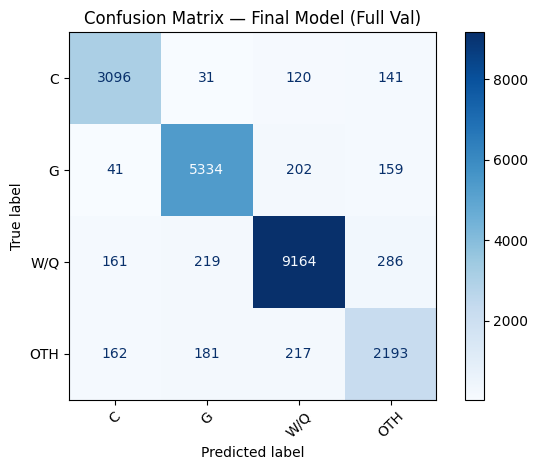

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_full = confusion_matrix(y_true_full, y_pred_full, labels=labels_present_full)
print("Confusion Matrix:\n", cm_full)

disp_full = ConfusionMatrixDisplay(confusion_matrix=cm_full,
                                   display_labels=[inv_label_map[i] for i in labels_present_full])
disp_full.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix — Final Model (Full Val)")
plt.tight_layout()
plt.show()


=== ROC AUCs (Full Val) ===
C: AUC = 0.9913
G: AUC = 0.9918
W/Q: AUC = 0.9876
OTH: AUC = 0.9742
Micro-average AUC: 0.9888
Macro-average AUC: 0.9862


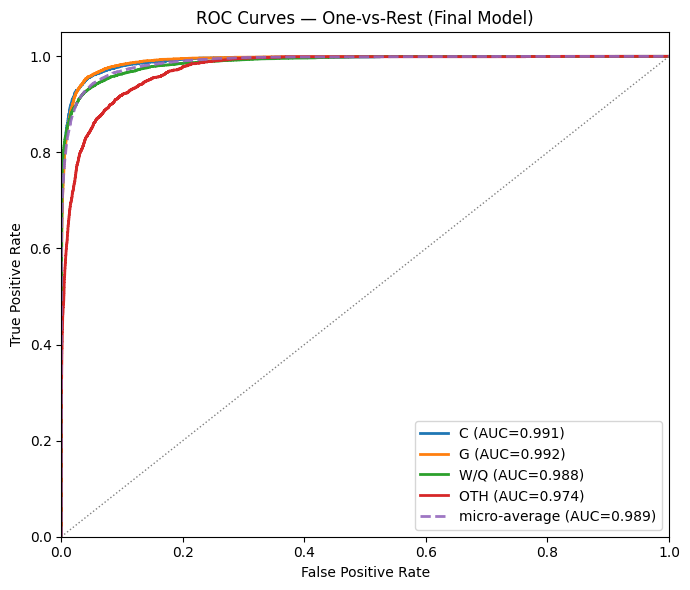

In [50]:
# ROC / AUC (one-vs-rest)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
probs_all_full = softmax(preds_full.predictions, axis=1)
y_true_bin_full = label_binarize(y_true_full, classes=labels_present_full)
probs_aligned_full = probs_all_full[:, labels_present_full]

fprs, tprs, aucs = {}, {}, {}
for j, cls_id in enumerate(labels_present_full):
    if y_true_bin_full[:, j].sum() == 0:
        continue
    fpr, tpr, _ = roc_curve(y_true_bin_full[:, j], probs_aligned_full[:, j])
    fprs[cls_id], tprs[cls_id] = fpr, tpr
    aucs[cls_id] = auc(fpr, tpr)

fpr_micro, tpr_micro, _ = roc_curve(y_true_bin_full.ravel(), probs_aligned_full.ravel())
auc_micro = auc(fpr_micro, tpr_micro)
auc_macro = float(np.mean(list(aucs.values()))) if len(aucs) > 0 else float("nan")

print("\n=== ROC AUCs (Full Val) ===")
for cls_id in labels_present_full:
    name = inv_label_map[cls_id]
    print(f"{name}: AUC = {aucs.get(cls_id, float('nan')):.4f}")
print(f"Micro-average AUC: {auc_micro:.4f}")
print(f"Macro-average AUC: {auc_macro:.4f}")

plt.figure(figsize=(7, 6))
for cls_id in labels_present_full:
    if cls_id in fprs:
        plt.plot(fprs[cls_id], tprs[cls_id], lw=2,
                 label=f"{inv_label_map[cls_id]} (AUC={aucs[cls_id]:.3f})")
plt.plot(fpr_micro, tpr_micro, lw=2, linestyle="--",
         label=f"micro-average (AUC={auc_micro:.3f})", alpha=0.9)
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle=":")
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves — One-vs-Rest (Final Model)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [51]:
# ---------- 7) Save final best model ----------
save_dir = "3_model/deberta-v3-best"
model_final.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)
print(f"\nSaved final best model to: {save_dir}")
print("Best HPO params used:",
      {**best_params, "max_length": best_max_length, "final_epochs": final_epochs})


Saved final best model to: 3_model/deberta-v3-best
Best HPO params used: {'learning_rate': 4.952154880820331e-05, 'weight_decay': 0.05782827280415942, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 1, 'warmup_ratio': 0.10428703312783645, 'max_length': 256, 'final_epochs': 3}
